In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

In [2]:
# Do these need to get imported still if they're imported in the other .py file? Idk

#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
#from sklearn.decomposition import IncrementalPCA
#from sklearn.decomposition import KernelPCA
#from sklearn.manifold import MDS
#from sklearn.manifold import Isomap

#from umap import UMAP  # <-- THIS IS NOT PART OF SCIPY

In [3]:
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [4]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

Version using dataframes (wasted way too much time writing this...)

In [5]:
def load_data(pIDs, data_dir_path="C:\\Users\\kdmen\\Box Sync\\$M data segmented\\segmented_filtered_data\\", file_types=["IMU_extract", "movavg_files"], expt_types=["experimenter-defined"]):
    
    data_dict = {}

    for expt_type in expt_types:
        for pid in pIDs:
            print(pid)
            pid_path = os.path.join(data_dir_path, pid)
            for file_type in file_types:
                sub_path = os.path.join(pid_path, file_type)
                if not os.path.exists(sub_path):
                    print(f"Subpath does not exist: {sub_path}")
                    continue
                for file in os.listdir(sub_path):
                    split_filename = file.split("_")
                    if len(split_filename) < 6:
                        print(f"Unexpected filename format: {file}")
                        continue
                    gestureID = split_filename[4]
                    gestureNum = split_filename[5]

                    if file_type == "movavg_files":
                        headers = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5',
                                   'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10',
                                   'EMG11', 'EMG12', 'EMG13', 'EMG14', 'EMG15',
                                   'EMG16']
                    else:
                        headers = ['IMU1_ax', 'IMU1_ay', 'IMU1_az', 'IMU1_vx', 'IMU1_vy', 'IMU1_vz',
                                   'IMU2_ax', 'IMU2_ay', 'IMU2_az', 'IMU2_vx', 'IMU2_vy', 'IMU2_vz',
                                   'IMU3_ax', 'IMU3_ay', 'IMU3_az', 'IMU3_vx', 'IMU3_vy', 'IMU3_vz',
                                   'IMU4_ax', 'IMU4_ay', 'IMU4_az', 'IMU4_vx', 'IMU4_vy', 'IMU4_vz',
                                   'IMU5_ax', 'IMU5_ay', 'IMU5_az', 'IMU5_vx', 'IMU5_vy', 'IMU5_vz',
                                   'IMU6_ax', 'IMU6_ay', 'IMU6_az', 'IMU6_vx', 'IMU6_vy', 'IMU6_vz',
                                   'IMU7_ax', 'IMU7_ay', 'IMU7_az', 'IMU7_vx', 'IMU7_vy', 'IMU7_vz',
                                   'IMU8_ax', 'IMU8_ay', 'IMU8_az', 'IMU8_vx', 'IMU8_vy', 'IMU8_vz',
                                   'IMU9_ax', 'IMU9_ay', 'IMU9_az', 'IMU9_vx', 'IMU9_vy', 'IMU9_vz',
                                   'IMU11_ax', 'IMU11_ay', 'IMU11_az', 'IMU11_vx', 'IMU11_vy', 'IMU11_vz',
                                   'IMU13_ax', 'IMU13_ay', 'IMU13_az', 'IMU13_vx', 'IMU13_vy', 'IMU13_vz',
                                   'IMU15_ax', 'IMU15_ay', 'IMU15_az', 'IMU15_vx', 'IMU15_vy', 'IMU15_vz']

                    file_path = os.path.join(sub_path, file)
                    if not os.path.exists(file_path):
                        print(f"File does not exist: {file_path}")
                        continue
                    df = pd.read_csv(file_path, names=headers, header=0)
                    if df.empty:
                        print(f"DataFrame is empty for file: {file_path}")
                        continue

                    df['Participant'] = pid
                    df['Gesture_ID'] = gestureID
                    df['Gesture_Num'] = gestureNum

                    # Interpolate the data 
                    df_interpolated = interpolate_df(df, num_rows=64, columns_to_exclude=['Participant', 'Gesture_ID', 'Gesture_Num'])

                    # Create a unique key based on Participant, Gesture_ID, and Gesture_Num
                    unique_key = (pid, gestureID, gestureNum)

                    if unique_key in data_dict:
                        # Merge the DataFrames on index to avoid duplicate columns
                        existing_df = data_dict[unique_key]
                        merged_df = existing_df.merge(df_interpolated, left_index=True, right_index=True, suffixes=('', '_dup'))
                        # Drop duplicate columns if necessary
                        for col in merged_df.columns:
                            if col.endswith('_dup'):
                                merged_df.drop(columns=col, inplace=True)
                        data_dict[unique_key] = merged_df
                    else:
                        data_dict[unique_key] = df_interpolated

    # Convert the dictionary to a list of DataFrames
    data_lst = list(data_dict.values())

    # Concatenate all dataframes into one
    print(f"Shape of first df: {data_lst[0].shape} (expected shape is (64, 91))")
    # ... does this work as expected... shouldn't it also be ele_df[0].shape
    edited_data_lst = [ele_df for ele_df in data_lst if ele_df.shape == data_lst[0].shape]
    dataframe = pd.concat(edited_data_lst, ignore_index=True)

    # Check for NaN values in the resulting dataframe
    nan_participant_rows = dataframe[dataframe['Participant'].isna()]
    print(f"Number of rows with NaN Participant: {nan_participant_rows.shape[0]}")
        
    return dataframe


In [6]:
start_time = time.time()
data_df = load_data(pIDs_both)
end_time = time.time()

print(f"\nCompleted in {end_time - start_time}")

pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
pid
Shape of first df: (64, 91) (expected shape is (64, 91))
Number of rows with NaN Participant: 0

Completed in 2459.6647131443024


In [7]:
print(data_df.shape)
data_df.head()

(426752, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [8]:
# Example dataframe, assuming 'df' is your dataframe
# Count NaNs per row
nans_per_row = data_df.isna().sum(axis=1)

# Count NaNs per column
nans_per_column = data_df.isna().sum(axis=0)


In [9]:
# Summary statistics for NaNs per row
nans_per_row.describe()

# Summary statistics for NaNs per column
#nans_per_column.describe()


count    426752.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

## Applying dimensionality reduction algorithms:

Modified version of Ben's PCA_all_participants() func

In [10]:
# Delete this later, just putting it here so I don't have to restart my kernel and reload in all the data...

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

def apply_model(model_str, input_df, num_dims, hp):
    
    # Drop the metadata columns (eg cols that are not the actual timeseries data)
    #input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num', 'Gesture_Type', 'File_Type'], inplace=True)
    training_df = input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num'])
    
    if not training_df.empty:
        if model_str.upper() == 'PCA':
            dim_reduc_model = PCA(n_components=num_dims)
            dim_reduc_model.fit(training_df)
            reduced_df = pd.DataFrame(dim_reduc_model.transform(training_df))
        elif model_str.upper() == 'T-SNE':
            dim_reduc_model = TSNE(n_components=num_dims, perplexity=hp, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(df))
        elif (model_str.upper() == 'INCREMENTALPCA') or (model_str.upper() == 'IPCA'):
            dim_reduc_model = IncrementalPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif (model_str.upper() == 'KERNELPCA') or (model_str.upper() == 'KPCA'):
            dim_reduc_model = KernelPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        #elif model_str.upper() == 'UMAP':
        #    raise ValueError("Need to install the umap library first...")
        #    dim_reduc_model = UMAP(n_components=num_dims)
        #    reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'MDS':
            dim_reduc_model = MDS(n_components=num_dims, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'ISOMAP':
            dim_reduc_model = Isomap(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        else:
            raise ValueError(f"{model_str} not implemented. Choose an implemented model.")
    else:
        raise ValueError(f"training_df is empty!")
    
    return reduced_df, dim_reduc_model

Testing in non-functionalized form first:

In [11]:
print("Start")

#def apply_dim_reduc(
model_str = 'PCA'
#data_df
num_dims=2
hp=None
modality=['EMG and IMU'],
participant_inclusion=['All'] #['Impaired', 'Unimpaired']

# ADD THIS TO FUNC!!!
apply='ALL'

###########################################

gestures = ['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate', 'select-single', 'delete', 'close', 'open']
data_types = modality
participant_types = participant_inclusion

for f_type in data_types:
    # My code assumes you are doing EMG and IMU together...
    ## Add slicing functionality later
    if f_type[0] == 'EMG and IMU':
        sel_df = data_df
    #elif f_type[0] == 'IMU':
    #    # slice just the IMU columns (cols with IMU in name)
    #elif f_type[0] == 'EMG':
    #    # slice just the EMG columns (cols with EMG in name)
    else:
        raise ValueError(f"f_type {f_type} not found in [EMG, IMU, EMG and IMU]")

    for p_type in participant_types:
        if p_type == "All":
            pIDs = sel_df['Participant'].unique()
        elif p_type == "Impaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_impaired)]['Participant'].unique()
        elif p_type == "Unimpaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_unimpaired)]['Participant'].unique()
        else:
            raise ValueError(f"Participant type {p_type} not supported, check supported versions.")

        if apply.upper() == 'ALL':
            df_t, dim_reduc_model = apply_model(model_str, sel_df, num_dims, hp)
        elif apply.upper() == 'BY USER':
            for pid in pIDs:
                for file_type in file_types:
                        user_df = sel_df[(sel_df['Participant'] == pid)]
                        df_t, dim_reduc_model = apply_model(model_str, user_df, num_dims, hp)
        elif apply.upper() == 'BY GESTURE':
            for file_type in file_types:
                for gesture in gestures:
                    gesture_df = sel_df[(data_df['Gesture_ID'] == gesture)]
                    df_t, dim_reduc_model = apply_model(model_str, gesture_df, num_dims, hp)

    #return df_t, dim_reduc_model

print("Success")

Start
Success


In [13]:
print(dim_reduc_model.explained_variance_)
print(dim_reduc_model.explained_variance_ratio_)

[2.11063503 1.48093676]
[0.20366441 0.14290207]


In [14]:
X = data_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num'])
print(X.shape)
X.head()

(426752, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,-0.888184,-0.334961,0.124514,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,-0.905297,-0.344967,0.144735,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,-0.905250,-0.343246,0.140630,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,-0.896252,-0.337100,0.185074,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,-0.903902,-0.343370,0.189500,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


1/88
2/88
3/88
4/88
5/88
6/88
7/88
8/88
9/88
10/88
11/88
12/88
13/88
14/88
15/88
16/88
17/88
18/88
19/88
20/88
21/88
22/88
23/88
24/88
25/88
26/88
27/88
28/88
29/88
30/88
31/88
32/88
33/88
34/88
35/88
36/88
37/88
38/88
39/88
40/88
41/88
42/88
43/88
44/88
45/88
46/88
47/88
48/88
49/88
50/88
51/88
52/88
53/88
54/88
55/88
56/88
57/88
58/88
59/88
60/88
61/88
62/88
63/88
64/88
65/88
66/88
67/88
68/88
69/88
70/88
71/88
72/88
73/88
74/88
75/88
76/88
77/88
78/88
79/88
80/88
81/88
82/88
83/88
84/88
85/88
86/88
87/88
88/88


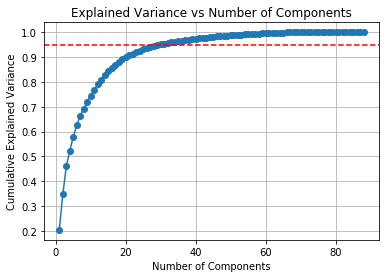

In [16]:
# Maximum number of components
max_comps = X.shape[1]

# Store explained variances for each number of components
explained_variances = []

for n in range(1, max_comps + 1):
    print(f"{n}/{max_comps}")
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Plot the cumulative explained variance
plt.plot(range(1, max_comps + 1), explained_variances, marker='o')
plt.axhline(y=0.95, linestyle="--", color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()


In [12]:
assert(1==0)

AssertionError: 

In [ ]:
def apply_dim_reduc(model_str, data_df, num_dims, hp=None, modality=['EMG and IMU'], participant_inclusion=['All Participants']):
    '''
    model_str: what kind of model to use (eg PCA, T-SNE, ...)
    data_df: df containing all the (training) data
    num_dims: how many dimensions/components should be used [HYPERPARAM!]
    hp: [hyperparams] use this to store 
    modality: ['EMG', 'IMU', 'EMG and IMU']
    '''
    
    pass
                

## Evaluation

In [ ]:
def eval_dim_reduc():
    # AIC? ...
    # For PCA can used explained variance
    ## Probably easier to not do this as a function, unless I use the same criteria for each method...
    pass

## Application

In [ ]:
# Need to do train/test splits?
# I have plenty of clustering metrics but not dim reduc specific ones...

## Choosing Optimal Number of Clusters

In [ ]:
assert(1==0)

> Elbow Plot

In [ ]:
from sklearn.cluster import KMeans

# determining the maximum number of clusters 
# using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)
 
# wcss - within cluster sum of squared distances
wcss = {}
 
for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    wcss[k] = model.inertia_
     
# plotting the wcss values to find the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

# determining the maximum number of clusters using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)

> Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, limit+1):
	model = KMeans(n_clusters=k)
	model.fit(dataset_new)
	pred = model.predict(dataset_new)
	score = silhouette_score(dataset_new, pred)
	print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))